In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import mutual_info_classif

In [3]:
df =pd.read_csv('../data/datasets/Bondora_filled.csv', low_memory=False)
df.head()

,BidsPortfolioManager,BidsApi,BidsManual,Age,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,IncomeTotal,...,MaritalStatus,EmploymentStatus,EmploymentDurationCurrentEmployer,OccupationArea,HomeOwnershipType,Rating,Restructured,WorseLateCategory,CreditScoreEsMicroL,Defaulted
0,970,1150,5.0,53,2125.0,2125.0,20.97,60,62.05,354.0,...,0,3,0,12,7,3,0,4,11,0
1,1295,0,1705.0,50,3000.0,3000.0,17.12,60,84.75,900.0,...,0,0,0,16,7,2,0,4,11,0
2,2700,565,5835.0,44,10630.0,9100.0,13.67,60,268.57,1200.0,...,1,0,7,17,5,0,0,4,11,1
3,1115,0,385.0,42,1500.0,1500.0,40.40,60,63.53,863.0,...,2,1,9,12,4,6,0,4,4,0
4,305,0,785.0,34,1595.0,1090.0,68.39,48,101.19,697.0,...,1,3,5,12,9,7,0,4,6,0


## Feature Selection: Mutual Information

In the preprocessing stage of the dataset we have indicated "Defaulted" feature to be a target variable. In order to identify features that are most relevant to a target variable, and reduce the dimension of the dataset we will use Mutual Information (MI). MI is selected as unified method across all the models. Also, since the study focuses on the identifying sustainable model, it was cruicial that feature selection process would not involve model training. 

In [4]:
X = df.copy()
y = X.pop("Defaulted")

disc_feat = X.dtypes == int

MI_ranking = mutual_info_classif(X, y, discrete_features=disc_feat)
MI_ranking = pd.Series(MI_ranking, name = "Mutual Info Ranking", index=X.columns)
MI_ranking = MI_ranking.sort_values(ascending=False)

MI_ranking

InterestAndPenaltyBalance                 0.605395
PrincipalBalance                          0.497012
WorseLateCategory                         0.423289
PrincipalOverdueBySchedule                0.402884
PrincipalPaymentsMade                     0.378045
PlannedInterestTillDate                   0.122195
ProbabilityOfDefault                      0.107320
ExpectedLoss                              0.093498
ExpectedReturn                            0.080652
LossGivenDefault                          0.071319
MonthlyPayment                            0.069522
RecoveryStage                             0.061936
Interest                                  0.060091
BidsPortfolioManager                      0.050334
InterestAndPenaltyPaymentsMade            0.046256
LanguageCode                              0.039945
Country                                   0.039473
Rating                                    0.038247
AppliedAmount                             0.037101
LoanDuration                   

First 15 features with the highest MI Score will be selected to proceed with the ML models.

Text(0, 0.5, 'Features')

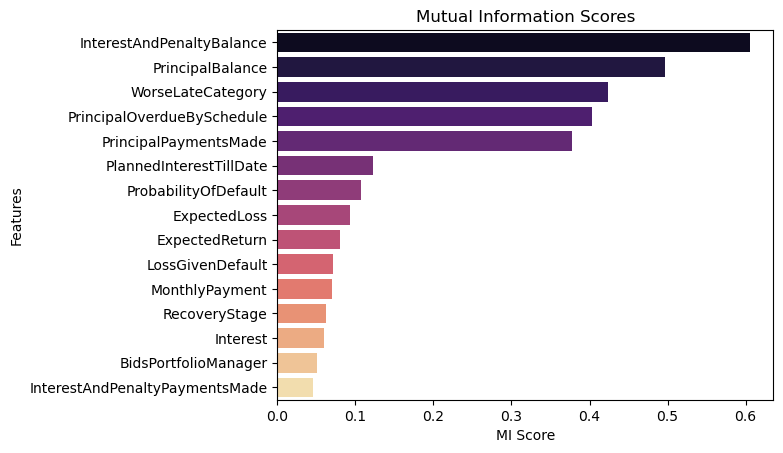

In [5]:
# sns.barplot(x=MI_ranking.values[:15], y=MI_ranking.index[:15], orient='h', palette="magma")
sns.barplot(x=MI_ranking.values[:15], y=MI_ranking.index[:15], orient='h', palette="magma")
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Features')

In [6]:
MI_selected = MI_ranking.index[:15]

<Axes: >

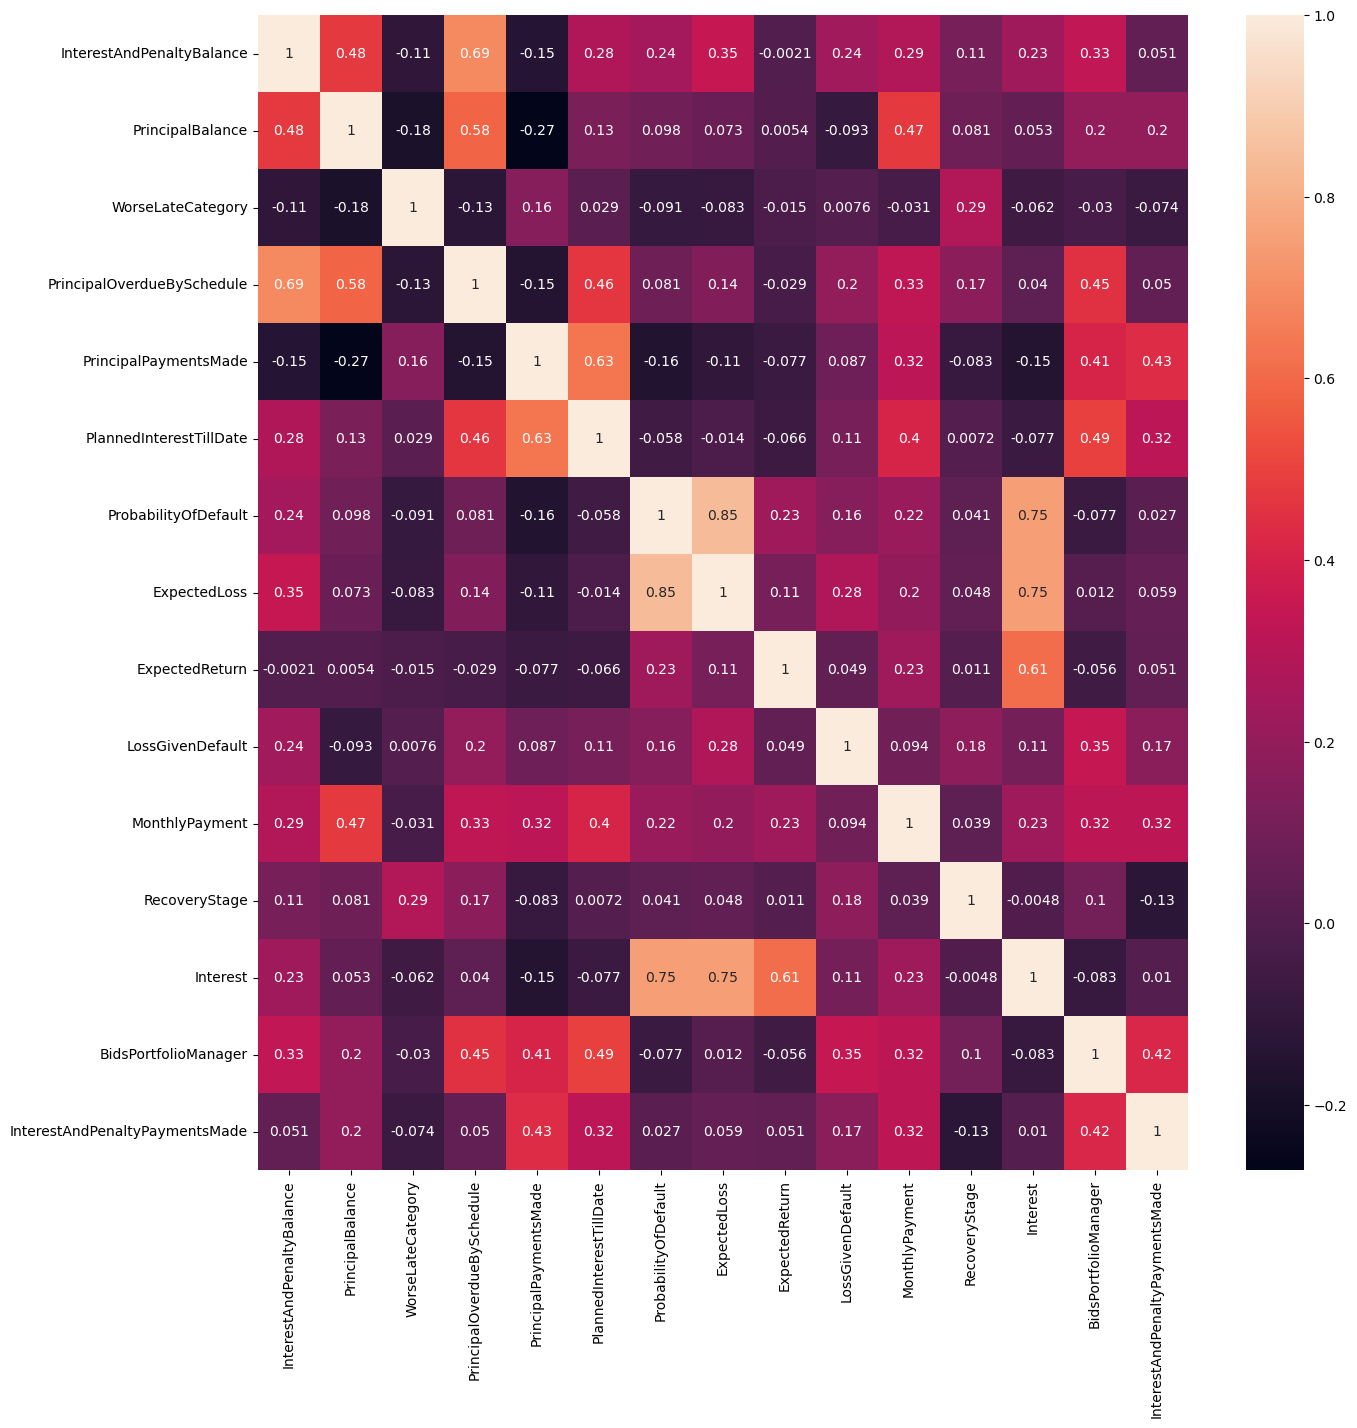

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(df[MI_selected].corr(), annot=True)

Based on the correlation matrix, features with correlation more than 0.8 would be removed to avoid redundancy.

<Axes: >

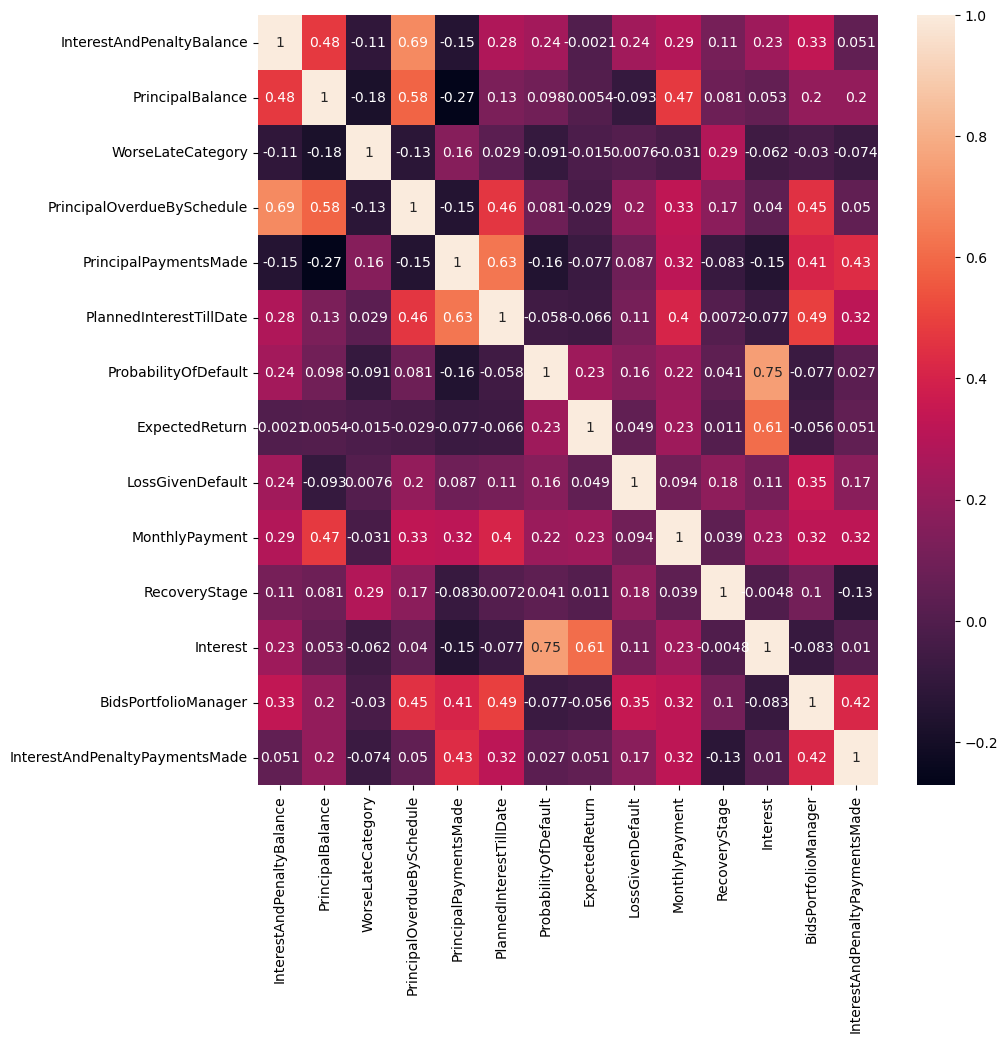

In [8]:
matrix = df[MI_selected].corr()
half = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(np.bool_))
highly_correlated = to_drop = [column for column in half.columns if any(abs(half[column]) > 0.8)]
df_reduced = df[MI_selected].drop(highly_correlated, axis = 1)

plt.figure(figsize=(10,10))
sns.heatmap(df_reduced.corr(), annot=True)

The final set of features to proceed with model training is 'InterestAndPenaltyBalance', 'PrincipalBalance', 'WorseLateCategory', 'PrincipalOverdueBySchedule', 'PrincipalPaymentsMade',
'PlannedInterestTillDate', 'ProbabilityOfDefault', 'ExpectedReturn', 'LossGivenDefault', 'MonthlyPayment', 'RecoveryStage', 'Interest', 'InterestAndPenaltyPaymentsMade', 'LanguageCode'

In [9]:
df_reduced.shape

(121461, 14)

## Hyperparameters Tuning and Cross Validation

In [10]:
from sklearn.tree import DecisionTreeClassifier
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix


In [11]:
X = df_reduced.values.astype(np.float32)
y = df["Defaulted"].values.astype(np.int32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)  
}


hyperparameters = {
    'Decision Tree': {
        'criterion' : ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'ccp_alpha': [0.0, 0.01, 0.1, 1.0]
    },
    'Logistic Regression': {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100]
    },
    'Random Forest': {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
    }}

[I] [19:55:09.033919] Unused keyword parameter: random_state during cuML estimator initialization


In [13]:
def tune_hyperparams(model, hyperparameters, X_train, y_train):
    try:
        GridSearch = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5, scoring='accuracy', n_jobs=1)
        GridSearch.fit(X_train, y_train)
        best_model = GridSearch.best_estimator_
        print(f"Best Parameters: {GridSearch.best_params_}")
        print(f"Best Cross-Validation Score: {GridSearch.best_score_}\n")
        return best_model
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [14]:
best_models = {}
for model_name, model in models.items():
    print(f"In progress: {model_name}")
    best_model = tune_hyperparams(model, hyperparameters[model_name], X_train, y_train)
    best_models[model_name] = best_model
    test_score = best_model.score(X_test, y_test)
    print(f"Test Score for {model_name} with Best Parameters: {test_score}")


In progress: Decision Tree
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10}
Best Cross-Validation Score: 0.9964803252797229

Test Score for Decision Tree with Best Parameters: 0.9966657061705018
In progress: Random Forest
Best Parameters: {'max_depth': 20, 'n_estimators': 50}
Best Cross-Validation Score: 0.9965729506957036

Test Score for Random Forest with Best Parameters: 0.9963364005088806
In progress: Logistic Regression
[W] [19:56:45.988680] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
Best Parameters: {'C': 100, 'penalty': 'l2'}
Best Cross-Validation Score: 0.9741375963701111

Test Score for Logistic Regression with Best Parameters: 0.9749310612678528


In [15]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, tree_method='hist', device='cuda')

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

def custom_scorer(estimator, X, y):
    estimator.fit(X, y, early_stopping_rounds=10, eval_set=[(X_val, y_val)], verbose=False)
    predictions = estimator.predict(X_val)
    return accuracy_score(y_val, predictions)

In [16]:
print("In progress: XGBoost")
grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring=custom_scorer, n_jobs=1)
grid_search.fit(X_train_sub, y_train_sub)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}\n")

test_score = best_model.score(X_test, y_test)
print(f"Test Score for XGBoost with Best Parameters: {test_score}")

In progress: XGBoost
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Cross-Validation Score: 0.9959575168779846

Test Score for XGBoost with Best Parameters: 0.9972008397480756


### Model Trainig and Analysis

In [41]:
from codecarbon import EmissionsTracker
import psutil
import GPUtil
from sklearn.model_selection import cross_val_predict

#### Decision Tree

In [42]:
models = {
    'Decision Tree' : DecisionTreeClassifier(criterion='gini', max_depth=10, ccp_alpha=0.0, random_state=42),
    'Random Forest' : RandomForestClassifier(max_depth=20, n_estimators = 50, random_state=42),
    'LogisticRegression' : LogisticRegression(C=100, penalty='l2')
}




In [43]:
def get_cpu():
    return psutil.cpu_percent(interval=1)

def get_gpu():
    gpus = GPUtil.getGPUs()
    print("GPU:", gpus)
    if len(gpus) > 0:
        return sum(gpu.load for gpu in gpus) / len(gpus) * 100
    else:
        return 0


def get_ram():
    memory = psutil.virtual_memory()
    return memory.used / (1024**3)

In [89]:
def emissions_analysis(tracker, name):
    print(f"Evaluating emissions: {name}")
    emission = tracker.final_emissions
    energy = tracker._total_energy.kWh
    cpu_use = tracker._total_cpu_energy.kWh
    gpu_use = get_gpu()
    ram_use = tracker._total_ram_energy.kWh

    emission = tracker.final_emissions
    energy = tracker._total_energy.kWh
    
    return {"Model" : name, "Energy consumption (kWh)" : energy, 
                     "Carbon Emissions (kg CO2)" : emission,
                     "CPU usage (kWh)" : cpu_use, 
                     "GPU usage (%)" : gpu_use, 
                     "Memory usage (kWh)" : ram_use}


def training(model, X_train, y_train, X_test, y_test, name):
    tracker = EmissionsTracker()
    tracker.start()
    model.fit(X_train, y_train)  # Fit the model on the training data
    tracker.stop()

    # Predictions should be made on the test set
    y_predict = model.predict(X_test)
    y_predict_proba = model.predict_proba(X_test)[:, 1]

    # Perform accuracy analysis on the test set
    accuracy_dt = accuracy_analysis(y_test, y_predict, y_predict_proba, name)
    emissions_dt = emissions_analysis(tracker, name)
    
    return accuracy_dt, emissions_dt, y_predict, y_predict_proba

def accuracy_analysis(y_true, y_predict, y_predict_probability, name):
    print(f"Evaluating Accuracy: {name}")
    accuracy = accuracy_score(y_true, y_predict)
    auc = roc_auc_score(y_true, y_predict_probability)
    f1 = f1_score(y_true, y_predict)
    return {
        "Model": name,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy,
        "Confusion matrix": confusion_matrix(y_true, y_predict)
    }



#### Decision Tree

In [90]:
print("Processing Decision Tree")
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10, ccp_alpha=0.0, random_state=42)
dt_acc, dt_em, y_predict_dt, y_predict_proba_dt = training(dt_model, X_train, y_train, X_test, y_test, "DT")

[codecarbon INFO @ 21:40:11] [setup] RAM Tracking...
[codecarbon INFO @ 21:40:11] [setup] GPU Tracking...
[codecarbon INFO @ 21:40:11] Tracking Nvidia GPU via pynvml


Processing Decision Tree


[codecarbon INFO @ 21:40:13] [setup] CPU Tracking...
[codecarbon WARNING @ 21:40:13] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:40:14] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon INFO @ 21:40:14] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:40:14] >>> Tracker's metadata:
[codecarbon INFO @ 21:40:14]   Platform system: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 21:40:14]   Python version: 3.11.9
[codecarbon INFO @ 21:40:14]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 21:40:14]   Available RAM : 15.461 GB
[codecarbon INFO @ 21:40:14]   CPU count: 20
[codecarbon INFO @ 21:40:14]   CPU model: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:40:14]   GPU count: 1
[codecarbon INFO @ 21:40:14]   GPU model: 1 x NVIDIA RTX A500 Laptop GPU
[codecarbon INFO @ 21:40:18] Energy cons

Evaluating Accuracy: DT
Evaluating emissions: DT
GPU: [<GPUtil.GPUtil.GPU object at 0x7f7229db6b90>]


#### Random Forest

In [91]:
print("Processing Random Forest")
rf_model = RandomForestClassifier(max_depth=20, n_estimators = 50, random_state=42)
rf_acc, rf_em, y_predict_rf, y_predict_proba_rf = training(rf_model, X_train, y_train, X_test, y_test, "RF")

[codecarbon INFO @ 21:40:58] [setup] RAM Tracking...
[codecarbon INFO @ 21:40:58] [setup] GPU Tracking...
[codecarbon INFO @ 21:40:58] Tracking Nvidia GPU via pynvml


Processing Random Forest


[codecarbon INFO @ 21:40:59] [setup] CPU Tracking...
[codecarbon WARNING @ 21:40:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:41:01] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon INFO @ 21:41:01] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:41:01] >>> Tracker's metadata:
[codecarbon INFO @ 21:41:01]   Platform system: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 21:41:01]   Python version: 3.11.9
[codecarbon INFO @ 21:41:01]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 21:41:01]   Available RAM : 15.461 GB
[codecarbon INFO @ 21:41:01]   CPU count: 20
[codecarbon INFO @ 21:41:01]   CPU model: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:41:01]   GPU count: 1
[codecarbon INFO @ 21:41:01]   GPU model: 1 x NVIDIA RTX A500 Laptop GPU
[codecarbon INFO @ 21:41:04] Energy cons

Evaluating Accuracy: RF
Evaluating emissions: RF
GPU: [<GPUtil.GPUtil.GPU object at 0x7f722a3a8b50>]


### Logistic Regression

In [92]:
print("Processing Logistic Regression")
lr_model = LogisticRegression(C=100, penalty='l2', random_state=42)
lr_acc, lr_em, y_predict_lr, y_predict_proba_lr = training(lr_model, X_train, y_train, X_test, y_test, "LR")

[codecarbon INFO @ 21:41:47] [setup] RAM Tracking...
[codecarbon INFO @ 21:41:47] [setup] GPU Tracking...
[codecarbon INFO @ 21:41:47] Tracking Nvidia GPU via pynvml


Processing Logistic Regression
[I] [21:41:47.140028] Unused keyword parameter: random_state during cuML estimator initialization


[codecarbon INFO @ 21:41:48] [setup] CPU Tracking...
[codecarbon WARNING @ 21:41:48] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:41:50] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon INFO @ 21:41:50] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:41:50] >>> Tracker's metadata:
[codecarbon INFO @ 21:41:50]   Platform system: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 21:41:50]   Python version: 3.11.9
[codecarbon INFO @ 21:41:50]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 21:41:50]   Available RAM : 15.461 GB
[codecarbon INFO @ 21:41:50]   CPU count: 20
[codecarbon INFO @ 21:41:50]   CPU model: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:41:50]   GPU count: 1
[codecarbon INFO @ 21:41:50]   GPU model: 1 x NVIDIA RTX A500 Laptop GPU
[codecarbon INFO @ 21:41:53] Energy cons

Evaluating Accuracy: LR
Evaluating emissions: LR
GPU: [<GPUtil.GPUtil.GPU object at 0x7f722b7f1b90>]


#### XGBoost

In [93]:
print("Processing XGBoost")
xgb_model = XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators=100, random_state=42)
xgb_acc, xgb_em, y_predict_xgb, y_predict_proba_xgb = training(xgb_model, X_train, y_train, X_test, y_test, "XGB")

[codecarbon INFO @ 21:42:12] [setup] RAM Tracking...
[codecarbon INFO @ 21:42:12] [setup] GPU Tracking...
[codecarbon INFO @ 21:42:12] Tracking Nvidia GPU via pynvml


Processing XGBoost


[codecarbon INFO @ 21:42:14] [setup] CPU Tracking...
[codecarbon WARNING @ 21:42:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:42:15] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700H but we don't know it. Please contact us.
[codecarbon INFO @ 21:42:15] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:42:15] >>> Tracker's metadata:
[codecarbon INFO @ 21:42:15]   Platform system: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35
[codecarbon INFO @ 21:42:15]   Python version: 3.11.9
[codecarbon INFO @ 21:42:15]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 21:42:15]   Available RAM : 15.461 GB
[codecarbon INFO @ 21:42:15]   CPU count: 20
[codecarbon INFO @ 21:42:15]   CPU model: 13th Gen Intel(R) Core(TM) i7-13700H
[codecarbon INFO @ 21:42:15]   GPU count: 1
[codecarbon INFO @ 21:42:15]   GPU model: 1 x NVIDIA RTX A500 Laptop GPU
[codecarbon INFO @ 21:42:18] Energy cons

Evaluating Accuracy: XGB
Evaluating emissions: XGB
GPU: [<GPUtil.GPUtil.GPU object at 0x7f722b7ae050>]


In [94]:
acc_total = pd.DataFrame([dt_acc, rf_acc, lr_acc, xgb_acc])
print(acc_total)

  Model  F1 Score       AUC  Accuracy              Confusion matrix
0    DT  0.996651  0.998114  0.996666    [[12159, 45], [36, 12053]]
1    RF  0.996329  0.999573  0.996336    [[12126, 78], [11, 12078]]
2    LR  0.975046  0.994120  0.974931  [[11786, 418], [191, 11898]]
3   XGB  0.997646  0.999929  0.997654    [[12158, 46], [11, 12078]]


In [96]:
green_total = pd.DataFrame([dt_em, rf_em, lr_em, xgb_em])
print(green_total)

  Model  Energy consumption (kWh)  Carbon Emissions (kg CO2)  CPU usage (kWh)  \
0    DT                  0.000007               2.360629e-06         0.000005   
1    RF                  0.000009               2.948634e-06         0.000005   
2    LR                  0.000002               7.277682e-07         0.000002   
3   XGB                  0.000004               1.436742e-06         0.000003   

   GPU usage (%)  Memory usage (kWh)  
0            0.0        7.234779e-07  
1           67.0        6.965456e-07  
2            5.0        2.048696e-07  
3            0.0        4.265275e-07  


## Transparency Analysis

In [117]:
import shap
from lime import lime_tabular

#### Decision Tree

In [126]:
dt_explainer = shap.TreeExplainer(dt_model, X_train)
shap_values_dt = dt_explainer(X_test)

np.shape(shap_values_dt.values)

(24293, 14, 2)

In [127]:
dt_model.predict_proba(X_test)[2]

array([1., 0.])

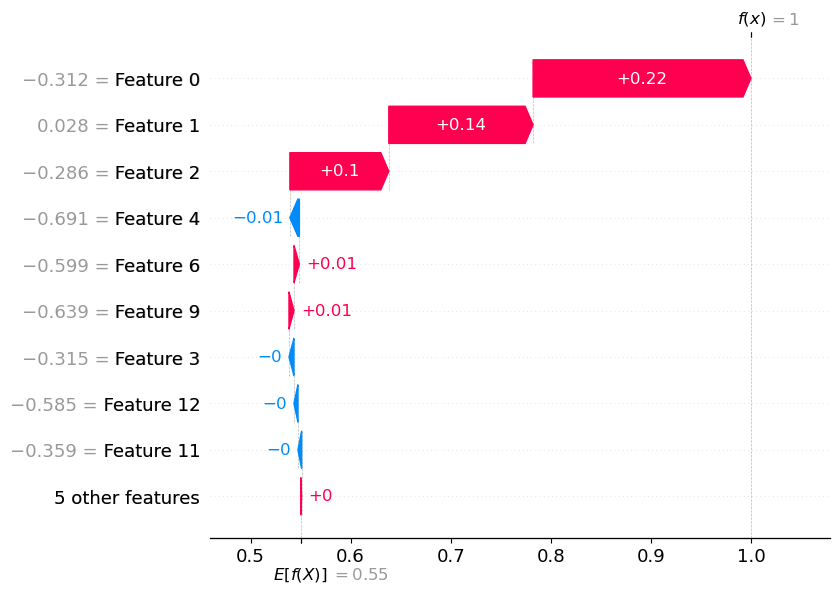

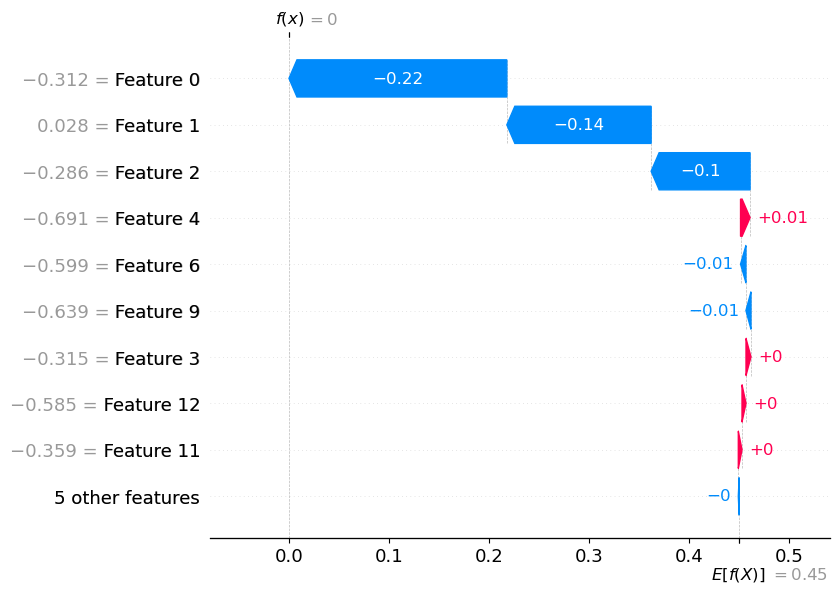

In [128]:
shap.plots.waterfall(shap_values_dt[2, : , 0])
shap.plots.waterfall(shap_values_dt[2, : , 1])

In [129]:
new_schap_values_dt = []
for i, prediction in enumerate(y_predict_dt):
    new_schap_values_dt.append(shap_values_dt.values[i][:,prediction])

shap_values_dt.values = np.array(new_schap_values_dt)
print(shap_values_dt.shape)

(24293, 14)


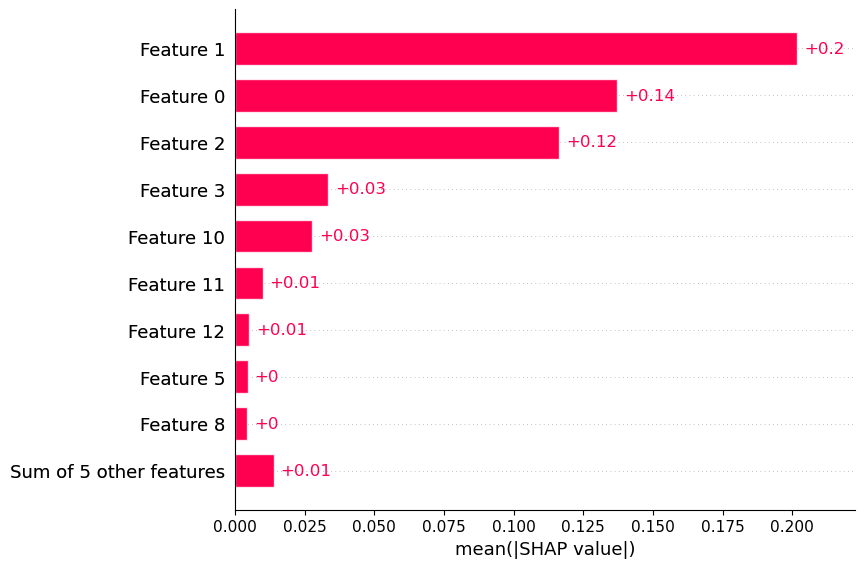

In [130]:
shap.plots.bar(shap_values_dt)

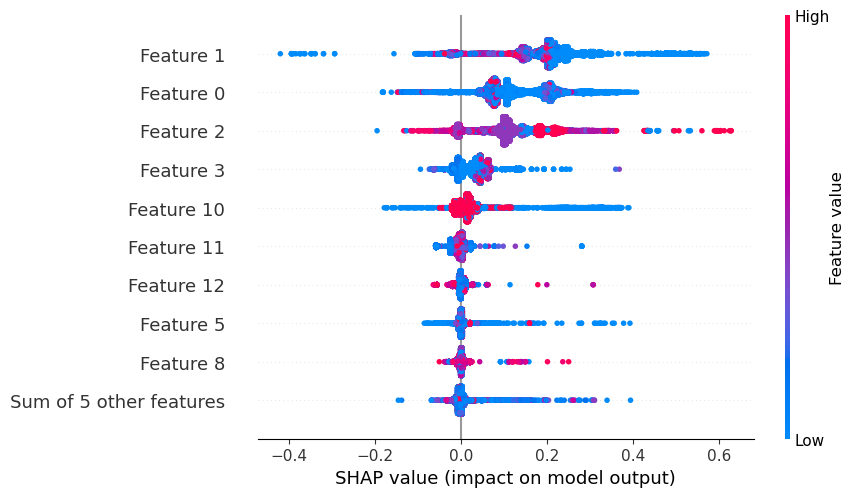

In [131]:
shap.plots.beeswarm(shap_values_dt)

### Logistic Regression

In [132]:
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)

In [133]:
np.shape(shap_values_lr.values)

(24293, 14)

In [134]:
import math
print(y_predict_lr[:5])
probabilities = y_predict_proba_lr[:5]
print(probabilities)
log_odds = []
for prob in probabilities:
    log_odd = math.log(prob/(1-prob))
    log_odds.append(log_odd)
print(log_odds)
print()

[0 1 0 1 0]
[3.45784663e-08 9.99986053e-01 3.05915773e-01 9.76254940e-01
 4.22863211e-09]
[-17.180034674961732, 11.180197270496842, -0.8192835056671794, 3.7163492538964964, -19.281387269939508]



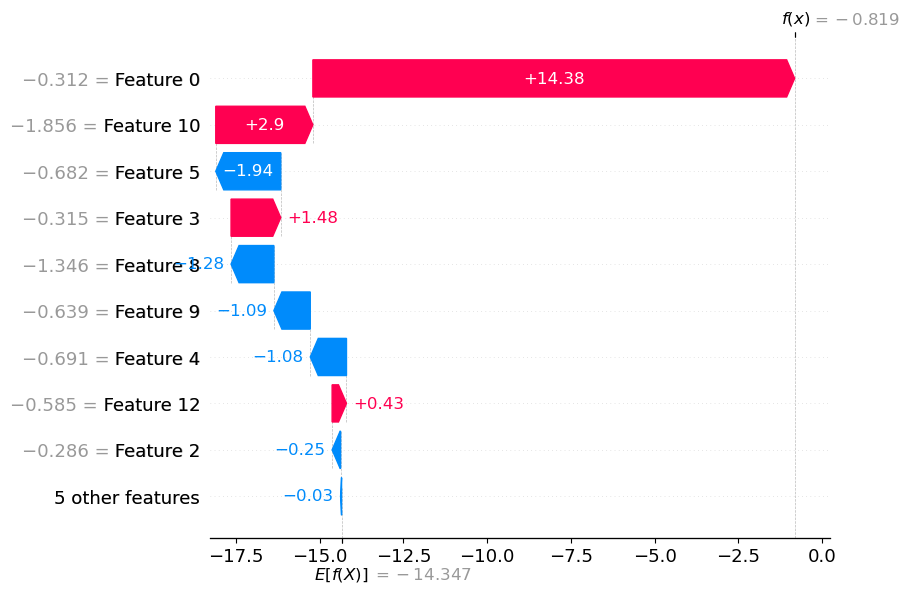

In [135]:
shap.plots.waterfall(shap_values_lr[2])

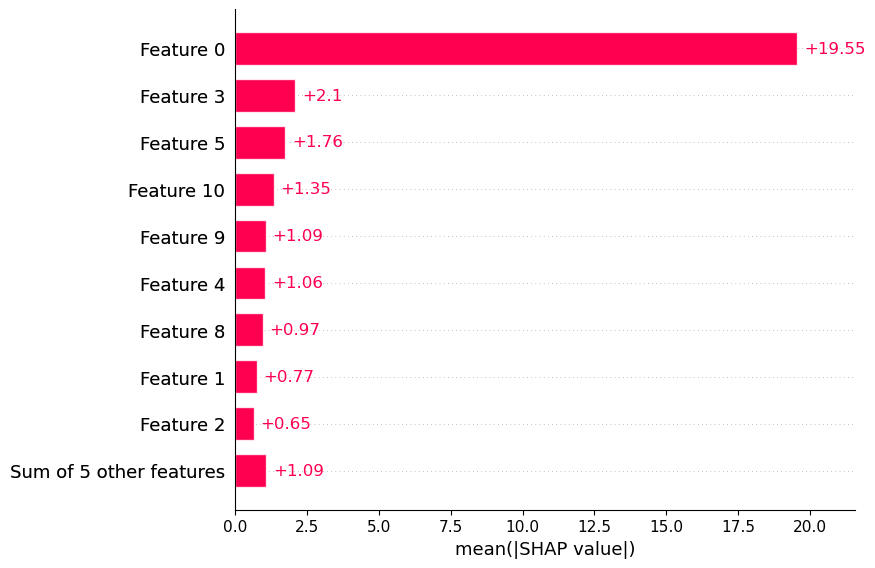

In [138]:
shap.plots.bar(shap_values_lr)

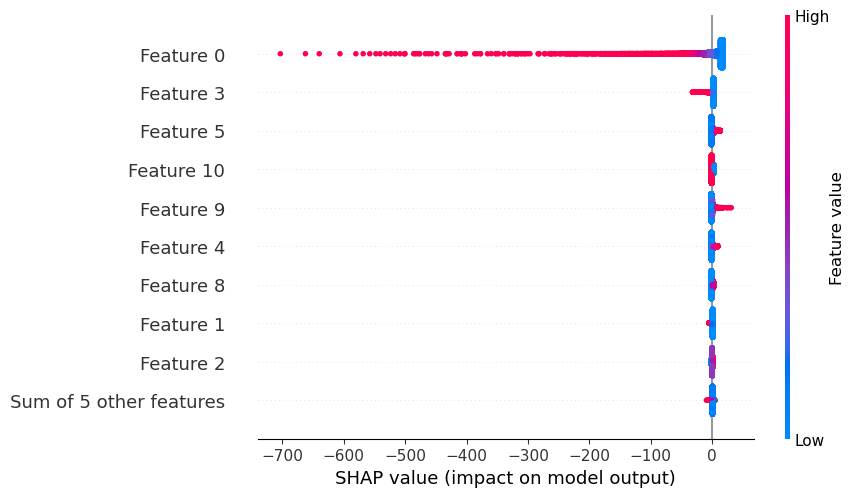

In [139]:
shap.plots.beeswarm(shap_values_lr)

#### XGBoost

In [140]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_model, X_train)
shap_values = explainer(X_test)

 98%|===================| 23706/24293 [00:34<00:00]        

In [141]:
np.shape(shap_values.values)

(24293, 14)

In [142]:
import math
print(y_predict_xgb[:5])
probabilities = y_predict_proba_xgb[:5]
print(probabilities)
log_odds = []
for prob in probabilities:
    log_odd = math.log(prob/(1-prob))
    log_odds.append(log_odd)
print(log_odds)
print()


[0 1 0 1 0]
[8.8675552e-05 9.9982041e-01 5.3099066e-04 9.9991214e-01 9.8954188e-05]
[-9.330437658230458, 8.62466118938568, -7.540235003060648, 9.339709399583333, -9.220754606291022]



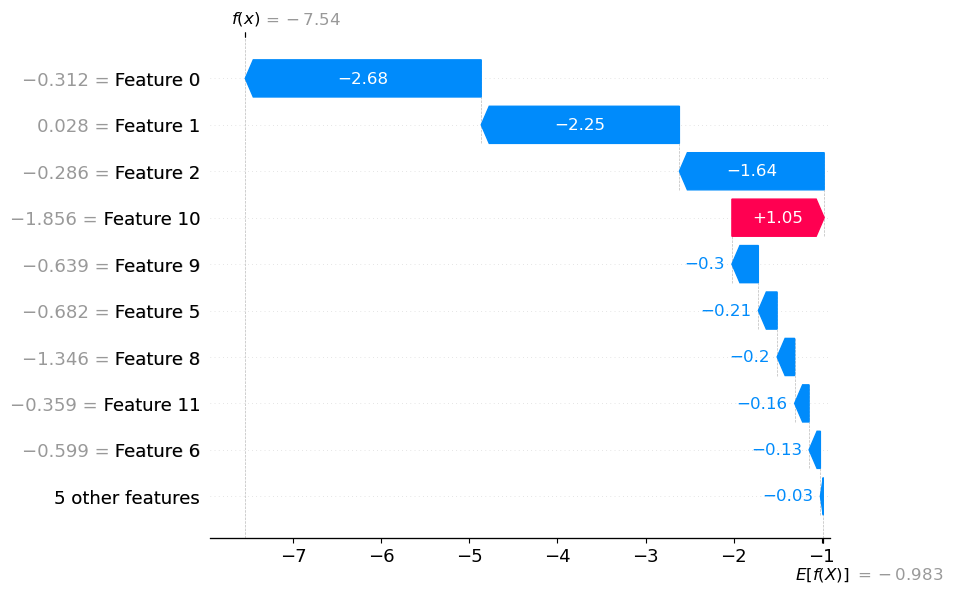

In [143]:
shap.plots.waterfall(shap_values[2])

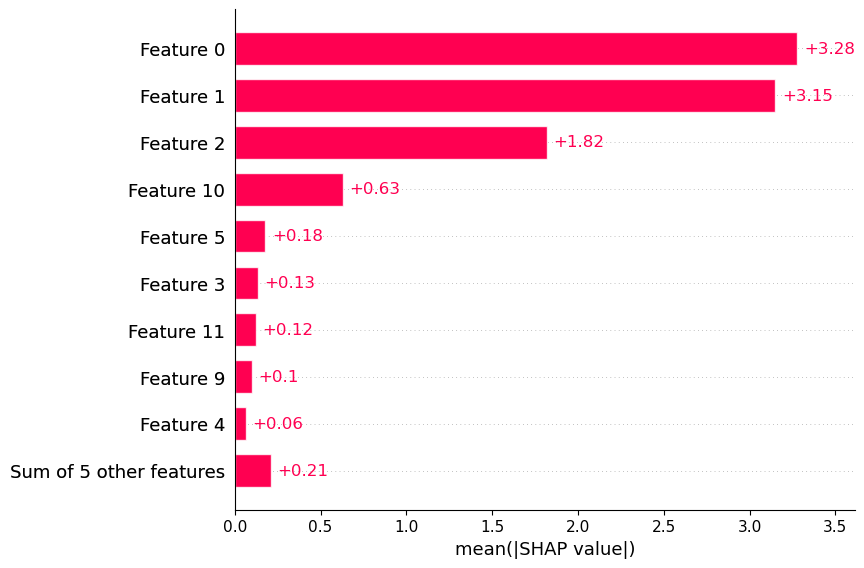

In [144]:
shap.plots.bar(shap_values)

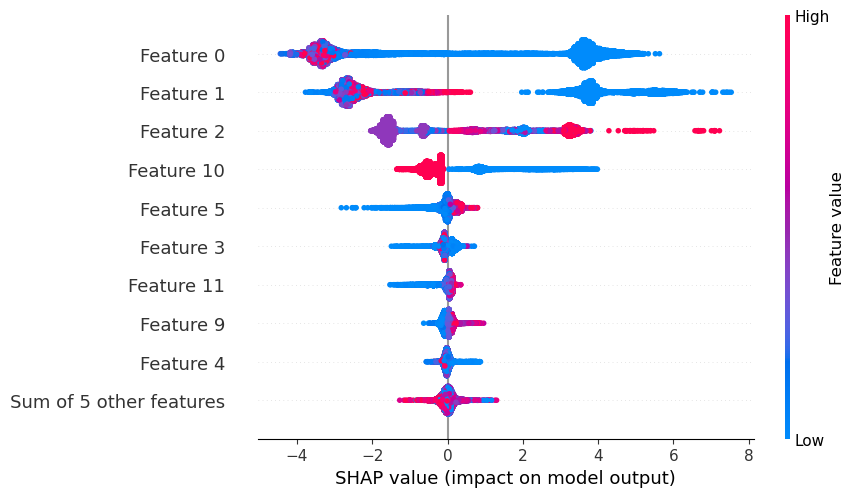

In [145]:
shap.plots.beeswarm(shap_values)

### LIME

#### Decision Tree

In [148]:
lime_explainer_dt = lime_tabular.LimeTabularExplainer(np.array(X_train), feature_names=X_train.columns, verbose=True, mode='classification')
explanation_dt = lime_explainer_dt.explain_instance(
    data_row=X_test.iloc[0],
    predict_fn=dt_model.predict_proba,
    num_features=5
)

explanation_dt.show_in_notebook(show_table = True)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'